<a target="_blank" href="https://colab.research.google.com/github/rcabanasdepaz/ME-BigData/blob/main/JAGS/MixGaussians_JAGS.ipynb">  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Mixtura de gausianas con modelos jerárquicos (JAGS)

A continuación se muestra cómo ajustar una mixtura de gausianas mediante un modelo probabilístico jerárquico.


In [ ]:
install.packages("R2OpenBUGS")
library(R2OpenBUGS)


system("sudo apt-get install -y jags") # Sólo para colab o sistemas Linux
install.packages("rjags")
library(rjags)


install.packages("coda")
library(coda)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘coda’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




## Conjunto de datos


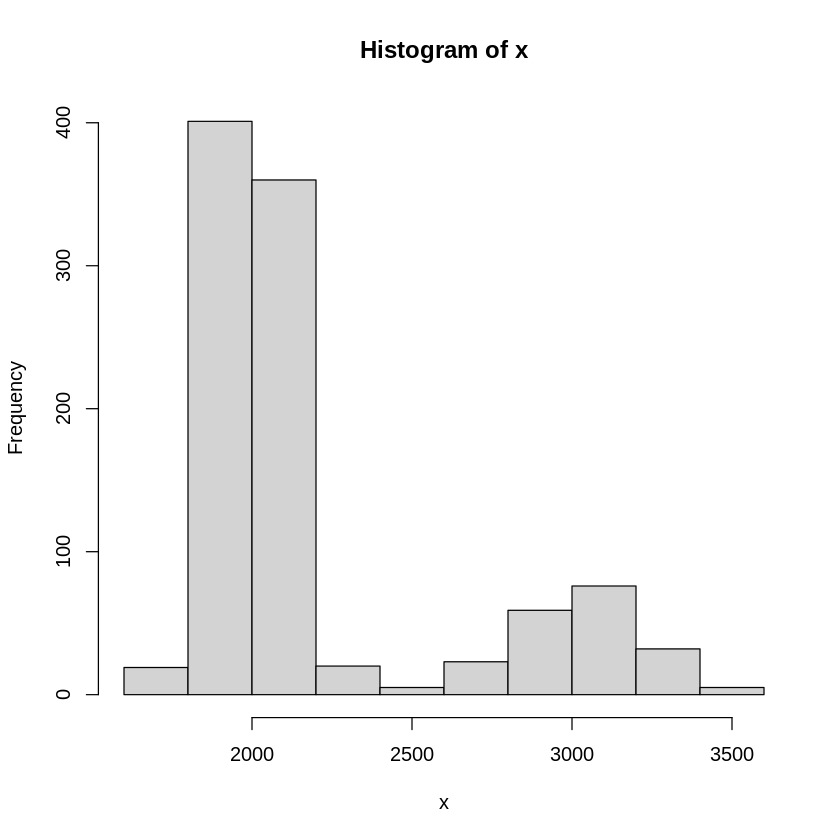

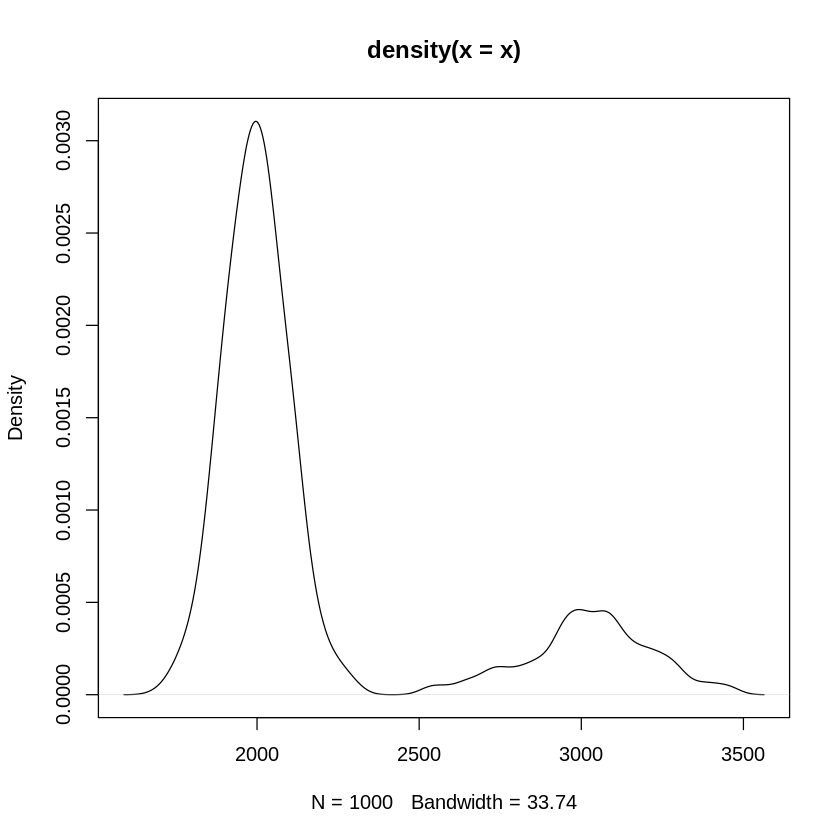

In [ ]:
# Generamos un conjunto de datos
set.seed(47405)
media <- c(2000,3000)
desv <- c(100,200)
ingresos1 <-rnorm(800,2000,100)
ingresos2 <-rnorm(200,3000,200)

x = c(ingresos1,ingresos2)
hist(x)
plot(density(x))

n = length(x)

# Necesitamos asignar como minimo 2 clusters
Ngrupos = 2
grupo = rep(NA,n)
grupo[which.min(x)]=1
grupo[which.max(x)]=2
dataList = list(
  x = x ,
  n = n ,
  Ngrupos = Ngrupos ,
  grupo = grupo ,
  paramGrupos = rep(1,Ngrupos)
)



## Modelo 1
### Definición
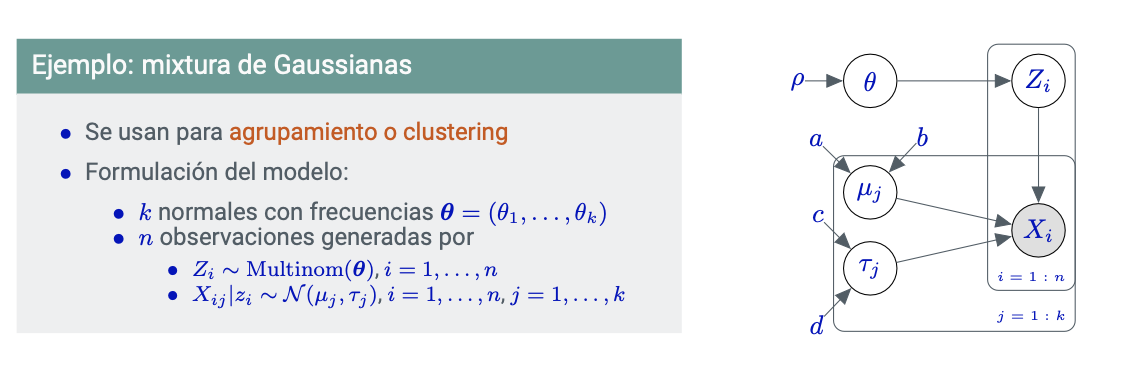

Podemos definir el modelo como una función:

In [ ]:
# Un modelo en rjags es una función
mod = function(){
  # Dist. a priori:
  for ( grupoId in 1: Ngrupos ) {
    muGrupo[grupoId] ~ dnorm( 0 , 1.0E-10 )
    tauGrupo[grupoId] ~ dgamma( 0.01 , 0.01 )
  }
  pGrupo[1:Ngrupos] ~ ddirch( paramGrupos )


  # verosimilitud
  for( i in 1 : n ) {
      x[i] ~ dnorm( mu[i] , tau[i] )
      mu[i] <- muGrupo[ grupo[i] ]
      tau[i] <- tauGrupo[grupo[i]]
      grupo[i] ~ dcat( pGrupo[1:Ngrupos] )
    }
}

### Inferencia

Puesto que JAGS es un software externo a R, para poder hacer inferencia hacer inferenc

In [ ]:

# hay que guardar el modelo en un archivo
model.file="model.txt"
write.model(mod,model.file)

# compilamos el modelo
jmod = jags.model(file = model.file, data=dataList, inits = NULL, n.adapt = 1000)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1002
   Unobserved stochastic nodes: 1003
   Total graph size: 4009

Initializing model



In [ ]:
update(jmod, n.iter=1000, by=1)

In [ ]:
# Muestreamos la secuencia completa
samples = jags.samples(jmod,c('grupo', 'x', 'mu','tau', 'grupo', 'muGrupo', 'tauGrupo', 'pGrupo'), 100)
theta = prop.table(table(samples$grupo))

Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for grupo
Monitor already exists and cannot be duplicated
”


In [ ]:
# calculamos la media de cada grupo de muestras
Grupo = apply(samples$grupo,1,mean)
Ingresos = apply(samples$x,1,mean)

df = data.frame(Grupo,Ingresos)

In [ ]:
df

Grupo,Ingresos
<dbl>,<dbl>
1,1996.208
1,2015.239
1,1948.426
1,1988.908
1,2028.702
1,1844.730
1,2070.060
1,2012.793
1,1980.294


In [ ]:
mu = c()
tau = c()

for ( i in 1: Ngrupos ) {
  mu[i] = mean(samples$mu[samples$grupo==i])
  tau[i] = mean(samples$tau[samples$grupo==i])
}

print(mu)
print(tau)

[1] 1996.055 3022.300
[1] 1.006149e-04 2.595663e-05


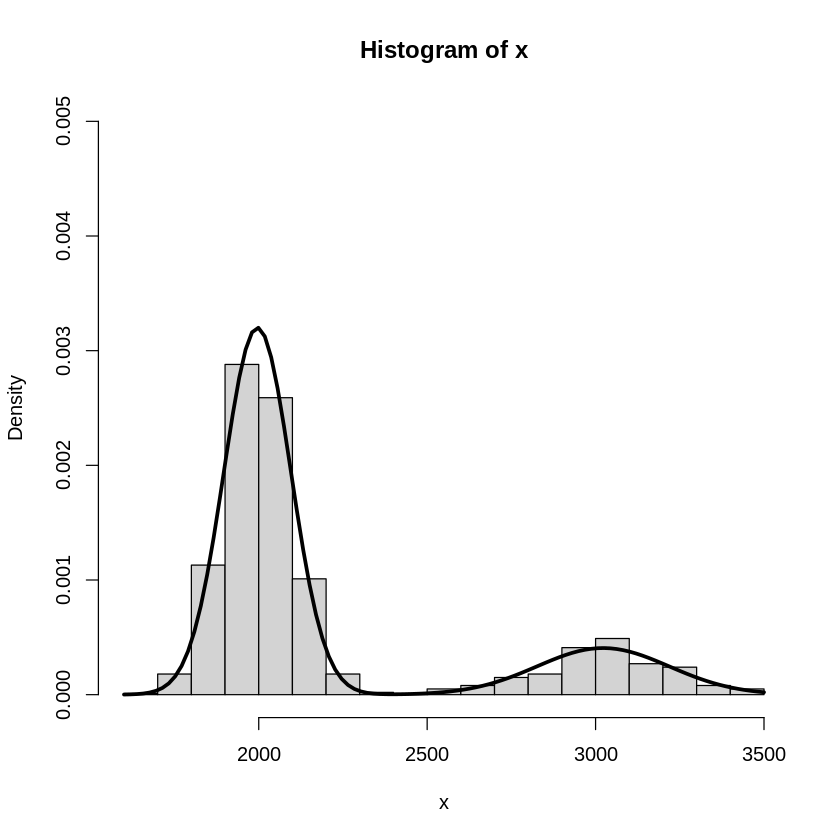

In [ ]:
mix <- function(x) {
  return(theta[1]*dnorm(x, mean=mu[1], sd=sqrt(1/tau[1])) + theta[2]*dnorm(x, mean=mu[2], sd=sqrt(1/tau[2])))
}
hist(x, breaks=20, probability = T, ylim = c(0,0.005))

curve(mix(x), add = T, lwd = 3)


## Ejercicios

- Indica cómo sería la versión extendida del modelo jerárquico.
- ¿Cómo sería una red Bayesiana híbrida equivalente?



## Enlaces
- Para crear notebooks con código en R: https://colab.research.google.com/#create=true&language=r